In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [4]:
from collections import defaultdict

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [69]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')


from zoo.unet import DPNUnet
from zoo.fpn import DPFPNet, FPNSumBottleneck, FPNDecoderBlock
from utils.attributes_dataset import ISIC_Dataset, EqualizedSampler, ValSampler, MEAN, STD, attributes

from utils.losses import BCEDiceJaccardLoss
from utils.metrics import calc_iou
from utils.hard_negative import HardNegativeMiner

from utils.attributes_augmentations import Augmentation, Crop
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# GPU_IDX = 1
EPS = 1e-5
LR_GAMMA = .95
SEED = 42
EPOCHS_NB = 50
IOUS = ['iou_attributes', 'iou_segment']
PATHS = {
    'DATA': '../data/cropped/',
}

In [8]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[(dataset.keys[idx], 0)]
    pred_mask = F.sigmoid(model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    channel = np.unique(np.where(true_mask)[-1]).min()
    pred_mask = pred_mask.T[..., channel]
    true_mask = true_mask[..., channel]
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask)
        ax[2].imshow(pred_mask)
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [9]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [10]:
def get_datasets(data_dir, fold, aug_strength=1.):
    amounts = pickle.load(open('../data/patches_amounts.pkl', 'rb'))
    train_dataset = ISIC_Dataset(data_dir, seed=SEED, amounts=amounts,
                                 augmentator=Augmentation, aug_params={'side': 512, 'strength': aug_strength}, part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, seed=SEED, amounts=amounts,
                               augmentator=Augmentation, aug_params={'side': 576}, is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_model(checkpoint=None, map_location=None, devices=None):
    model = DPFPNet(6, 3, encoder_name='dpn92', model_type='unet', dropout=0.3)
    model.cuda(CUDA_IDX);

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    if checkpoint is not None:
        cbs = torch.load(checkpoint, map_location)
        model.load_state_dict(cbs.module.state_dict())

    return model

In [11]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)

In [12]:
def visualize(im, mask=None, pred=None):
    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    plt.imshow((im[0].numpy().T * STD + MEAN)[..., ::-1])
    if mask is not None:
        plt.subplot(222)
        plt.imshow(mask.sum(0).numpy().T)
    if pred is not None:
        plt.subplot(223)
        plt.imshow(pred[..., :-1].sum(-1).T)
        plt.subplot(224)
        plt.imshow(pred[..., -1].T)
    plt.show()

In [13]:
model_pth = 'attributes_checkpoints/fpn_dpn92/fold_{}_checkpoint.epoch_49'
devices = None
data_dir = '../data/cropped_full/'

def infer(model_pth, devices, data_dir, fold, last_iter=0):
    _, val_dataset = get_datasets(data_dir, fold, 1.)
    model = get_model(model_pth, None, devices)
    model.eval()
    items = list(val_dataset.paths.items())
    with torch.no_grad():
        for i, (k, el) in enumerate(items[last_iter:]):
            preds = list()
            is_inshape = False
            path = os.path.basename(el['image'].format(0))
            path = os.path.join(data_dir, path.replace('.jpg', '.npy'))
            if os.path.isfile(path):
                continue

            for idx in tqdm(range(el['amount']), total=el['amount']):
                data = val_dataset[(k, idx)]
                im = np.rollaxis(data['images'].numpy(), 0, 3)
                if im.shape != (576, 576, 3):
                    is_inshape = True
                    print(k, el)
                    break
                im = _rotate_mirror_do(im)
                im = torch.tensor(np.rollaxis(im, -1, 1))

                predictions = model(Variable(im).cuda(CUDA_IDX))
                pred = F.sigmoid(predictions).data.cpu().numpy()
                pred = _rotate_mirror_undo(np.rollaxis(pred, 1, 4))
                preds.append(pred)

            if is_inshape:
                continue

            np.save(
                path, 
                np.array(preds)
            )

            if i % 10 == 0:
                clear_output(wait=True)
                print('Iteration {} / {}'.format(i + last_iter, len(val_dataset)))
                visualize(data, im, pred)


In [ ]:
model_pth = 'attributes_checkpoints/dpn92/fold_{}_checkpoint.epoch_49'
fold = 1
infer(model_pth.format(fold), devices, data_dir, fold)

100%|██████████| 648/648 [00:00<00:00, 107194.20it/s]
../zoo/abstract_model.py:184: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight.data = torch.nn.init.kaiming_normal(m.weight.data)


# Classification Task

In [14]:
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose


MEAN = [0.46764078, 0.52520324, 0.67566734]
STD = [0.13644579, 0.12332337, 0.09122486]

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.46764078, 0.52520324, 0.67566734], std=[0.13644579, 0.12332337, 0.09122486])
])


class ISIC_Dataset(Dataset):
    def __init__(self, root, augmentator=None, aug_params={}, apply_transform=True):
        self.augmentator = augmentator
        self.aug_params = aug_params
        self.augmentations = augmentator(**self.aug_params)
        self.apply_transform = apply_transform

        self.paths = {}
        
        template=os.path.join(root, '*.jpg')
        paths = sorted(glob(template))

        for path in tqdm(paths):
            key = os.path.basename(path).split('.')[0]
            self.paths[key] = {
                'image': path,
            }
        self.keys = list(self.paths.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, key):
        img = cv2.imread(self.paths[key]['image'])
        if self.augmentations is not None:
            img = self.augmentations(img, is_test=True)
        return {
            'key': key,
            'images': img_transform(img) if self.apply_transform else img, 
        }


In [15]:
model_pth = 'attributes_checkpoints/fpn_dpn92/fold_{}_checkpoint.epoch_49'
devices = None
data_dir = '../data/ISIC2018_Task3_Training_Input/'
out_dir = '../data/Task3TrainingAttributes/'

In [16]:
dataset = ISIC_Dataset(
    data_dir,
    augmentator=Augmentation, 
    aug_params={'side': 448}
)

100%|██████████| 10015/10015 [00:00<00:00, 665029.99it/s]


In [17]:
def infer(model_pth, devices, dataset, fold, out_dir=''):
    model = get_model(model_pth, None, devices)
    model.eval()
    with torch.no_grad():
        for i, (k, el) in tqdm(enumerate(dataset.paths.items())):
            preds = list()
            is_inshape = False
            path = os.path.basename(el['image']).replace('.jpg', '_{}.npy')
            path = os.path.join(out_dir, path.format(fold))
            if os.path.isfile(path):
                continue

            data = dataset[k]
            im = np.rollaxis(data['images'].numpy(), 0, 3)

            if im.shape != (448, 448, 3):
                is_inshape = True
                print(k, el)
                continue

            im = _rotate_mirror_do(im)
            im = torch.tensor(np.rollaxis(im, -1, 1))

            predictions = model(Variable(im).cuda(CUDA_IDX))
            pred = F.sigmoid(predictions).data.cpu().numpy()
            pred = _rotate_mirror_undo(np.rollaxis(pred, 1, 4))

            np.save(path, np.array(pred))

            if i % 100 == 0:
                clear_output(wait=True)
                print('Iteration {} / {}'.format(i, len(dataset)))
                visualize(im, mask=None, pred=pred)


Iteration 10010 / 10015


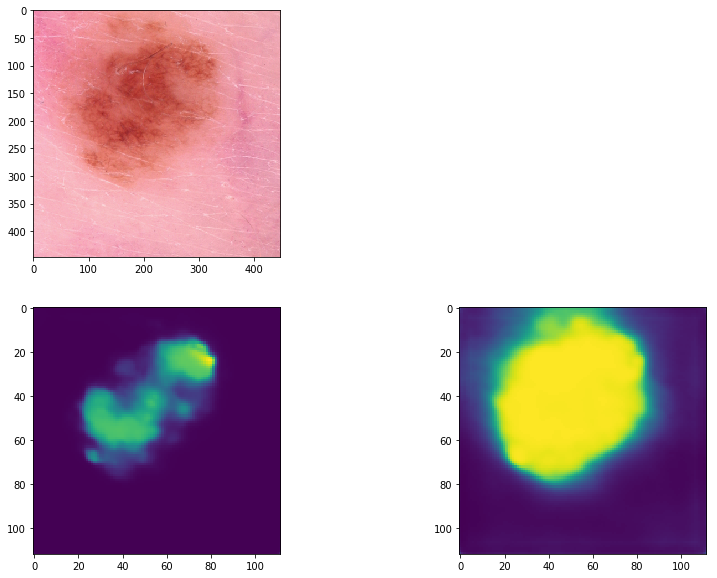

10015it [1:23:47,  1.99it/s]


In [39]:
fold = 0
infer(model_pth.format(fold), None, dataset, fold, out_dir)

Iteration 9900 / 10015


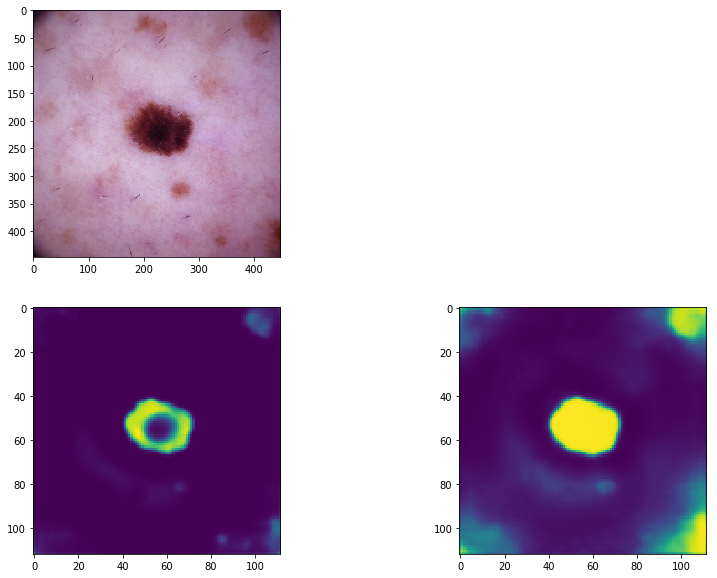

10015it [1:08:20,  2.44it/s]


In [18]:
fold = 1
infer(model_pth.format(fold), None, dataset, fold, out_dir)

Iteration 10000 / 10015


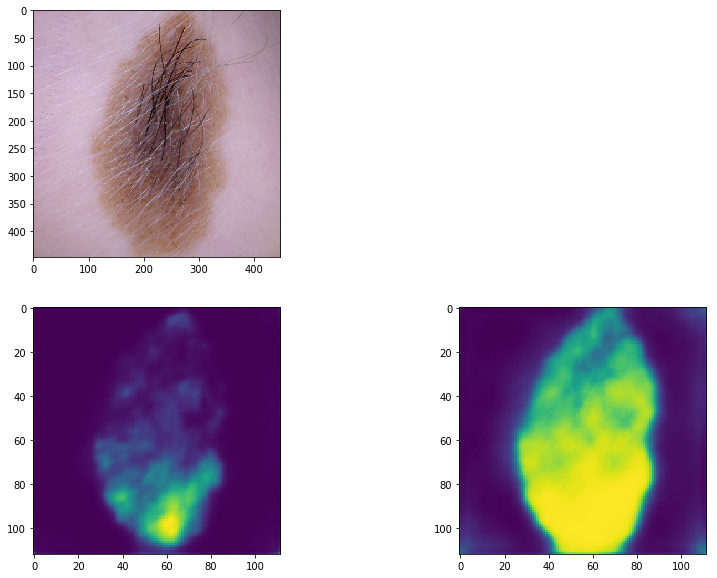

10015it [1:20:37,  2.07it/s]


In [19]:
fold = 2
infer(model_pth.format(fold), None, dataset, fold, out_dir)

Iteration 10000 / 10015


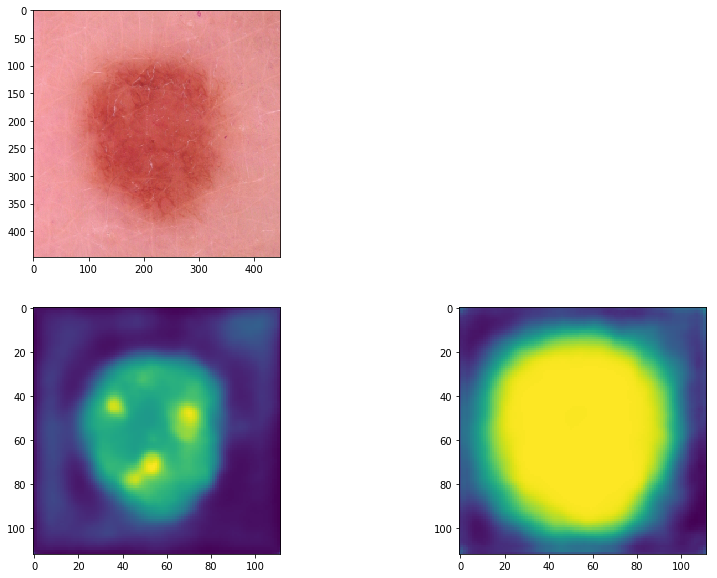

10015it [1:18:33,  2.12it/s]


In [23]:
fold = 3
infer(model_pth.format(fold), None, dataset, fold, out_dir)

# SLIC coverage

In [18]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import scipy.ndimage

slic_params = {
    'n_segments': 400,
    'compactness': 10,
    'sigma': 0,
    'convert2lab': True,
    'max_iter': 100,
}

In [19]:
dataset = ISIC_Dataset(
    data_dir,
    augmentator=Augmentation, 
    aug_params={'side': 448},
    apply_transform=False
)

100%|██████████| 10015/10015 [00:00<00:00, 205879.25it/s]


In [20]:
def apply_slic(dataset, out_dir=''):
    for i, (k, el) in tqdm(enumerate(dataset.paths.items())):
        path = os.path.basename(el['image']).replace('.jpg', '_{}.npy')
        path = os.path.join(out_dir, path.format('slic'))
        if os.path.isfile(path):
            continue

        data = dataset[k]
        image = data['images'][..., ::-1]
        segments = slic(image, **slic_params)
        np.save(path, segments)

        if i % 100 == 0:
            clear_output(wait=True)
            print('Iteration {} / {}'.format(i, len(dataset)))
            plt.figure(figsize=(10, 10))
            plt.imshow(mark_boundaries(image, segments))
            plt.show()

Iteration 10000 / 10015


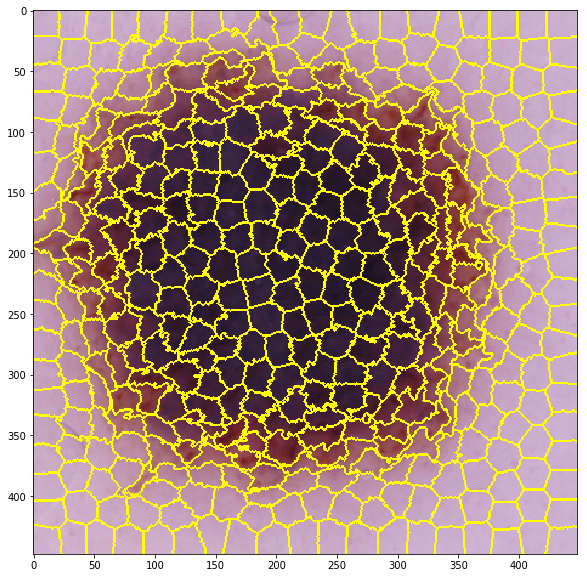

10015it [3:35:52,  1.29s/it]


In [55]:
apply_slic(dataset, out_dir)

# Aggregation

In [21]:
data_dir = '../data/Task3TrainingAttributes/'
template = '{}_{}.npy'

In [84]:
for key in dataset.keys:
    preds = list()
    for i in range(4):
        name = template.format(key, i)
        path = os.path.join(data_dir, name)
        preds.append(np.load(path))
    preds = np.power(np.product(preds, axis=0), .25)
    name = template.format(key, 'slic')
    path = os.path.join(data_dir, name)
    slic_image = np.load(path)
#     preds = np.mean(preds, axis=0)
    preds = np.dstack([
        cv2.resize(preds[..., i], (448, 448)) 
        for i in range(preds.shape[-1])
    ])
    colours = slic_image.max()

    new_preds = np.zeros_like(preds)
    for colour in range(colours):
        area = slic_image == (colour + 1)
        new_preds[area] += preds[area].mean(axis=0) > .5

    break

In [ ]:
plt.figure(figsize=(10, 10))

plt.imshow(new_preds[..., 5])

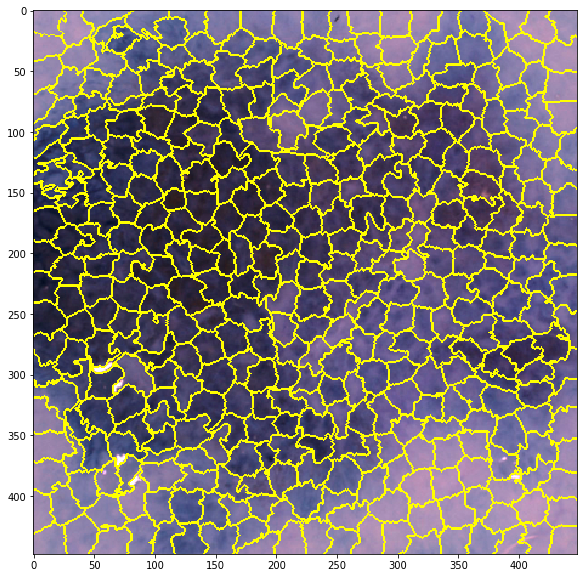

In [73]:
crop = Crop((448, 448), central=True)

image = cv2.imread('../data/ISIC2018_Task3_Training_Input/{}.jpg'.format(key))
plt.figure(figsize=(10, 10))
image = crop.augment_image(image)
plt.imshow(mark_boundaries(image, slic_image))